In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [7]:
POS_PATH

'data\\positive'

In [ ]:
!tar -xf lfw.tgz

In [8]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [9]:
import uuid

In [10]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\eb4def78-f629-11ec-a28e-b803058baf19.jpg'

In [ ]:
os.listdir('lfw')

In [11]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [12]:
frame

array([[[ 93, 121,  92],
        [ 98, 133, 101],
        [103, 142, 107],
        ...,
        [143, 138, 133],
        [143, 141, 136],
        [145, 144, 136]],

       [[ 97, 121,  92],
        [104, 131,  99],
        [110, 139, 103],
        ...,
        [147, 141, 129],
        [150, 142, 131],
        [152, 144, 133]],

       [[105, 115,  87],
        [111, 126,  96],
        [114, 136, 102],
        ...,
        [147, 139, 123],
        [154, 141, 122],
        [157, 141, 120]],

       ...,

       [[ 59,  56,  43],
        [ 66,  57,  49],
        [ 69,  60,  66],
        ...,
        [ 44, 112, 135],
        [ 50, 115, 145],
        [ 55, 113, 149]],

       [[ 57,  59,  47],
        [ 65,  61,  53],
        [ 76,  71,  76],
        ...,
        [ 43, 109, 129],
        [ 47, 111, 142],
        [ 49, 112, 148]],

       [[ 51,  61,  51],
        [ 60,  65,  62],
        [ 76,  81,  92],
        ...,
        [ 44, 106, 128],
        [ 43, 108, 137],
        [ 45, 113, 142]]

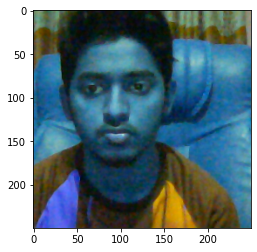

In [13]:
plt.imshow(frame)

In [14]:
frame[:250, :250, :].shape

(250, 250, 3)

In [ ]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [15]:
import os
import uuid

In [16]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [17]:
dir_test = anchor.as_numpy_iterator()

In [18]:
print(dir_test.next())

b'data\\anchor\\2a150ea6-f3ff-11ec-b66f-b803058baf19.jpg'


In [19]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [20]:
img = preprocess('data\\anchor\\26b006fa-f3ff-11ec-b5b5-b803058baf19.jpg')

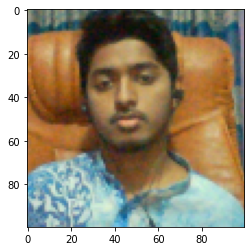

In [21]:
plt.imshow(img)

In [22]:
img.numpy().min() 

0.0

In [23]:
img.numpy().max() 

0.9610294

In [ ]:
dataset.map(preprocess)

In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [25]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [26]:
samples = data.as_numpy_iterator()

In [27]:
example = samples.next()

In [28]:
example

(b'data\\anchor\\286299da-f3ff-11ec-a98b-b803058baf19.jpg',
 b'data\\positive\\040ec752-f3fe-11ec-af3b-b803058baf19.jpg',
 1.0)

In [29]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [30]:
res = preprocess_twin(*exampple)

NameError: name 'exampple' is not defined

In [31]:
plt.imshow(res[1])

NameError: name 'res' is not defined

In [32]:
res[2]

NameError: name 'res' is not defined

In [33]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [34]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [35]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [36]:
inp = Input(shape=(100,100,3), name='input_image')

In [37]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [38]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [39]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [40]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [41]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [42]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [43]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [44]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [45]:
embedding = make_embedding()

In [46]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

In [47]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [48]:
l1 = L1Dist()

In [49]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [50]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [51]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [52]:
siamese_layer = L1Dist()

In [53]:
distances = siamese_layer(inp_embedding, val_embedding)

In [54]:
classifier = Dense(1, activation='sigmoid')(distances)

In [55]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [56]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [57]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [58]:
def make_siamese_model(): 
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [59]:
siamese_model = make_siamese_model()

In [60]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

In [61]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [62]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [63]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [64]:
test_batch = train_data.as_numpy_iterator()

In [65]:
batch_1 = test_batch.next()

In [66]:
X = batch_1[:2]

In [67]:
y = batch_1[2]

In [68]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [69]:
tf.losses.BinaryCrossentropy??

In [70]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [71]:
from tensorflow.keras.metrics import Precision, Recall

In [72]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        r = Recall()
        p = Precision()
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [73]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)

In [74]:
from tensorflow.keras.metrics import Precision, Recall

In [75]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [76]:
y_hat = siamese_model.predict([test_input, test_val])

In [77]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [78]:
[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]

[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]

In [79]:
y_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [80]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

0.0

In [81]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

0.0

In [82]:
r = Recall()
p = Precision()
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 
print(r.result().numpy(), p.result().numpy())

0.5 0.012820513


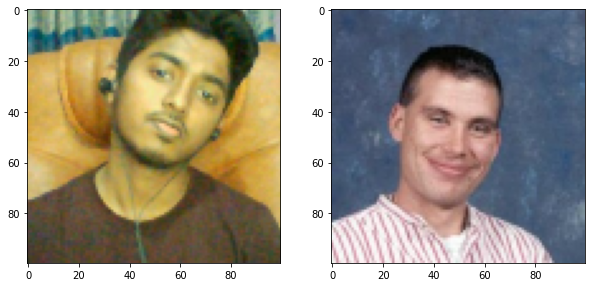

In [83]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [84]:
siamese_model.save('siamesemodelv2.h5')

In [85]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [86]:
siamese_model.predict([test_input, test_val])

array([[0.50171125],
       [0.5020299 ]], dtype=float32)

In [87]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [88]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    return results, verified

In [ ]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    cv2.imshow('Verification', frame)
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
results